In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Phase 1: EDA

Step 1: Data Collection

In [2]:
import zipfile
zip_path = '/content/drive/MyDrive/Colab Notebooks/sds-smart-leaf-project/crop_disease.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/crop_disease')

In [3]:
dataset_path = '/content/crop_disease'

Step 2: Define Paths and Initialize Counters

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

dataset_path = '/content/crop_disease/data'
splits = ['train', 'validation', 'test']
class_counts = defaultdict(lambda: defaultdict(int))
image_shapes = []

Step 3: Count Images per Class and Detect Issues

In [5]:
for split in splits:
    split_path = os.path.join(dataset_path, split)
    for class_name in os.listdir(split_path):
        class_folder = os.path.join(split_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    class_counts[split][class_name] += 1
                    if len(image_shapes) < 20:
                        image_shapes.append(img.shape)
                else:
                    print(f"Unreadable image: {img_path}")
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

 EDA Step 4: Print Class Distribution per Split

In [6]:
for split in splits:
    print(f"\n--- {split.upper()} SPLIT ---")
    for class_name, count in class_counts[split].items():
        print(f"{class_name}: {count} images")


--- TRAIN SPLIT ---
Corn___Gray_Leaf_Spot: 359 images
Wheat___Yellow_Rust: 646 images
Rice___Leaf_Blast: 683 images
Wheat___Healthy: 781 images
Rice___Brown_Spot: 429 images
Potato___Late_Blight: 700 images
Rice___Neck_Blast: 700 images
Wheat___Brown_Rust: 631 images
Corn___Northern_Leaf_Blight: 689 images
Corn___Common_Rust: 834 images
Potato___Healthy: 106 images
Rice___Healthy: 1041 images
Potato___Early_Blight: 700 images
Corn___Healthy: 813 images

--- VALIDATION SPLIT ---
Corn___Gray_Leaf_Spot: 77 images
Wheat___Yellow_Rust: 139 images
Rice___Leaf_Blast: 147 images
Wheat___Healthy: 167 images
Rice___Brown_Spot: 92 images
Potato___Late_Blight: 150 images
Rice___Neck_Blast: 150 images
Wheat___Brown_Rust: 135 images
Corn___Northern_Leaf_Blight: 148 images
Corn___Common_Rust: 179 images
Potato___Healthy: 23 images
Rice___Healthy: 223 images
Potato___Early_Blight: 150 images
Corn___Healthy: 174 images

--- TEST SPLIT ---
Corn___Gray_Leaf_Spot: 77 images
Wheat___Yellow_Rust: 139 image

 EDA Step 4: Show One Sample Image per Split

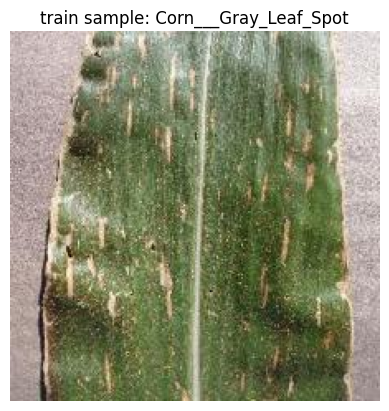

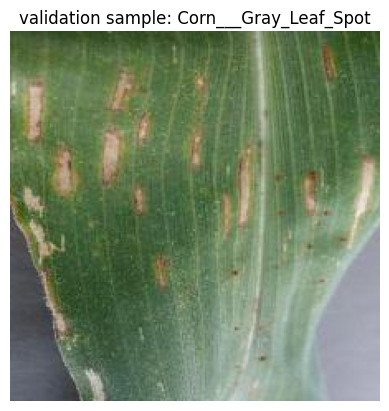

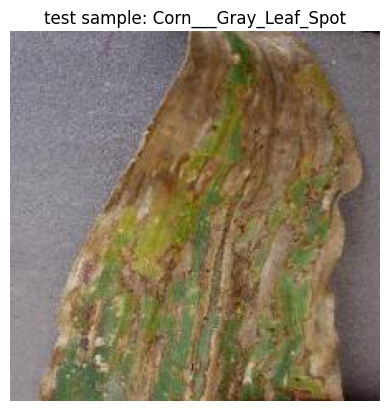

In [7]:
for split in splits:
    split_classes = list(class_counts[split].keys())
    if not split_classes:
        print(f"No classes found in {split}")
        continue
    sample_class = split_classes[0]
    sample_dir = os.path.join(dataset_path, split, sample_class)
    sample_image = os.listdir(sample_dir)[0]
    img = cv2.imread(os.path.join(sample_dir, sample_image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(f"{split} sample: {sample_class}")
    plt.axis('off')
    plt.show()

Step 6: Define Data Generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
image_size = (224, 224)
batch_size = 32
dataset_path = '/content/crop_disease/data'

# Data generator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generators for validation and test (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

Step 7: Load Images from Folders

In [9]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No shuffling for test set
)

Found 9112 images belonging to 15 classes.
Found 1954 images belonging to 15 classes.
Found 1958 images belonging to 15 classes.


# Phase 2: Model Architecture & Training

Auxillary Step 1: Address Class Imbalances before training

In [10]:
# Print class distribution in training set
for cls, count in class_counts['train'].items():
    print(f"{cls}: {count}")

Corn___Gray_Leaf_Spot: 359
Wheat___Yellow_Rust: 646
Rice___Leaf_Blast: 683
Wheat___Healthy: 781
Rice___Brown_Spot: 429
Potato___Late_Blight: 700
Rice___Neck_Blast: 700
Wheat___Brown_Rust: 631
Corn___Northern_Leaf_Blight: 689
Corn___Common_Rust: 834
Potato___Healthy: 106
Rice___Healthy: 1041
Potato___Early_Blight: 700
Corn___Healthy: 813


Noticeable class imbalance identified
•	Largest class: Rice___Healthy with 2082 images
•	Smallest class: Potato___Healthy with only 212 images

Auxillary Step 2: Compute Class Weights

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from the generator
labels = train_generator.classes  # Automatically extracted from folder names

# Compute weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Map weights to class indices
class_weights = dict(enumerate(class_weights_array))

##*1st Model*

Step 1.1: Import Libraries and Define the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 1.2: Compile the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Step 1.3: Train the Model (1st Attempt)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 405ms/step - accuracy: 0.3013 - loss: 2.1514 - val_accuracy: 0.6377 - val_loss: 0.9764
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 110s 385ms/step - accuracy: 0.6023 - loss: 1.0761 - val_accuracy: 0.7160 - val_loss: 0.7630
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 109s 384ms/step - accuracy: 0.6431 - loss: 0.9089 - val_accuracy: 0.7467 - val_loss: 0.5691
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 109s 383ms/step - accuracy: 0.6865 - loss: 0.7638 - val_accuracy: 0.7554 - val_loss: 0.5265
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 142s 386ms/step - accuracy: 0.7173 - loss: 0.6912 - val_accuracy: 0.7549 - val_loss: 0.5016
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 388ms/step - accuracy: 0.7363 - loss: 0.6432 - val_accuracy: 0.7042 - val_loss: 0.7548
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 109s 383ms/step - accuracy: 0.7261 - loss: 0.6788 - val_accuracy: 0.7984 - val_loss: 0.4848
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 113s 396ms/step - accuracy: 0.7534 -

Training Accuracy - 78.0%
Validation Accuracy - 83.1%
Training Loss - 0.53
Validation Loss - 0.41


##*2nd Model*

Step 2.1: Data Augmentation (Boost Generalization)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

Step 2.2: Improve Model Depth (Architecture)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 2.3: Compile the Model


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Step 2.4: Train the Model(2nd Attempt)




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model.h5',
                             monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6093 - loss: 1.4691

285/285 ━━━━━━━━━━━━━━━━━━━━ 113s 395ms/step - accuracy: 0.6093 - loss: 1.4685 - val_accuracy: 0.5005 - val_loss: 5.4488
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6547 - loss: 1.0669

285/285 ━━━━━━━━━━━━━━━━━━━━ 115s 404ms/step - accuracy: 0.6547 - loss: 1.0667 - val_accuracy: 0.6208 - val_loss: 1.7579
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 113s 396ms/step - accuracy: 0.6914 - loss: 0.9392 - val_accuracy: 0.4985 - val_loss: 3.8473
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 390ms/step - accuracy: 0.7058 - loss: 0.9495 - val_accuracy: 0.5435 - val_loss: 3.3103
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7446 - loss: 0.6965

285/285 ━━━━━━━━━━━━━━━━━━━━ 112s 394ms/step - accuracy: 0.7446 - loss: 0.6966 - val_accuracy: 0.6602 - val_loss: 1.1431
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 140s 388ms/step - accuracy: 0.7400 - loss: 0.6792 - val_accuracy: 0.4580 - val_loss: 6.7908
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7413 - loss: 0.7212

285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 419ms/step - accuracy: 0.7412 - loss: 0.7211 - val_accuracy: 0.7718 - val_loss: 0.7662
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 138s 406ms/step - accuracy: 0.7583 - loss: 0.6066 - val_accuracy: 0.7108 - val_loss: 0.9413
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 391ms/step - accuracy: 0.7524 - loss: 0.6648 - val_accuracy: 0.7170 - val_loss: 0.7148
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 112s 391ms/step - accuracy: 0.7549 - loss: 0.6637 - val_accuracy: 0.7334 - val_loss: 0.8539
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 389ms/step - accuracy: 0.7770 - loss: 0.6264 - val_accuracy: 0.3971 - val_loss: 14.9223
Epoch 12/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 390ms/step - accuracy: 0.7480 - loss: 0.6943 - val_accuracy: 0.6438 - val_loss: 1.8583


##*3rd* Model

Step 3.1: Rebuild Data Generator (moderate augmentations)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9112 images belonging to 15 classes.
Found 1954 images belonging to 15 classes.
Found 1958 images belonging to 15 classes.


Step 3.2 : Define Simplified + Regularized CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

Step 3.3 : Compile and Train the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/attempt3_best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5295 - loss: 1.4202
Epoch 1: val_accuracy improved from -inf to 0.09110, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 126s 412ms/step - accuracy: 0.5299 - loss: 1.4189 - val_accuracy: 0.0911 - val_loss: 6.5057 - learning_rate: 0.0010
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7478 - loss: 0.6649
Epoch 2: val_accuracy improved from 0.09110 to 0.51382, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 391ms/step - accuracy: 0.7478 - loss: 0.6648 - val_accuracy: 0.5138 - val_loss: 1.2123 - learning_rate: 0.0010
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7759 - loss: 0.5542
Epoch 3: val_accuracy did not improve from 0.51382
285/285 ━━━━━━━━━━━━━━━━━━━━ 115s 404ms/step - accuracy: 0.7759 - loss: 0.5542 - val_accuracy: 0.3316 - val_loss: 4.7267 - learning_rate: 0.0010
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8123 - loss: 0.4693
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.51382
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 388ms/step - accuracy: 0.8123 - loss: 0.4693 - val_accuracy: 0.4063 - val_loss: 7.1027 - learning_rate: 0.0010
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8367 - loss: 0.4033
Epoch 5: val_accuracy improved from 0.51382 to 0.84237, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 112s 394ms/step - accuracy: 0.8367 - loss: 0.4033 - val_accuracy: 0.8424 - val_loss: 0.3492 - learning_rate: 5.0000e-04
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8417 - loss: 0.3752
Epoch 6: val_accuracy did not improve from 0.84237
285/285 ━━━━━━━━━━━━━━━━━━━━ 140s 387ms/step - accuracy: 0.8417 - loss: 0.3752 - val_accuracy: 0.8019 - val_loss: 0.4893 - learning_rate: 5.0000e-04
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8558 - loss: 0.3570
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: val_accuracy did not improve from 0.84237
285/285 ━━━━━━━━━━━━━━━━━━━━ 113s 397ms/step - accuracy: 0.8558 - loss: 0.3570 - val_accuracy: 0.5097 - val_loss: 2.3058 - learning_rate: 5.0000e-04
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8586 - loss: 0.3344
Epoch 8: val_accuracy did not improve from 0.84237
285/285 ━━━━━━━━━━━━━━━━━━━━ 110s 387ms/step - accuracy: 0.

Step 3.4 : Model Evaluation

In [ ]:
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Map back to class names
class_names = list(test_generator.class_indices.keys())
predicted_labels = [class_names[i] for i in y_pred]
true_labels = [class_names[i] for i in y_true]

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8718 - loss: 0.2806
Test Accuracy: 0.8294
Test Loss: 0.3724


In [ ]:
model.save('/content/drive/MyDrive/smart_leaf_final.keras')

##*4th* Model - Best

Step 4.1 : Define the Architecture with L2 Regularization

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Classification Head
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 4.2: Compile with RMSprop and Train

In [13]:
model.compile(
    optimizer=RMSprop(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Define Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Define Model Checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/attempt3_best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.5512 - loss: 1.4863
Epoch 1: val_accuracy improved from -inf to 0.11771, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 141s 447ms/step - accuracy: 0.5515 - loss: 1.4850 - val_accuracy: 0.1177 - val_loss: 5.4783 - learning_rate: 0.0010
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7564 - loss: 0.7402
Epoch 2: val_accuracy improved from 0.11771 to 0.50512, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 417ms/step - accuracy: 0.7565 - loss: 0.7401 - val_accuracy: 0.5051 - val_loss: 1.6522 - learning_rate: 0.0010
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7961 - loss: 0.6229
Epoch 3: val_accuracy did not improve from 0.50512
285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 417ms/step - accuracy: 0.7961 - loss: 0.6229 - val_accuracy: 0.3992 - val_loss: 4.0072 - learning_rate: 0.0010
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8109 - loss: 0.5627
Epoch 4: val_accuracy improved from 0.50512 to 0.70471, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 416ms/step - accuracy: 0.8109 - loss: 0.5626 - val_accuracy: 0.7047 - val_loss: 0.8314 - learning_rate: 0.0010
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8273 - loss: 0.5292
Epoch 5: val_accuracy did not improve from 0.70471
285/285 ━━━━━━━━━━━━━━━━━━━━ 118s 413ms/step - accuracy: 0.8273 - loss: 0.5292 - val_accuracy: 0.6622 - val_loss: 1.0319 - learning_rate: 0.0010
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8306 - loss: 0.4909
Epoch 6: val_accuracy improved from 0.70471 to 0.78199, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 422ms/step - accuracy: 0.8307 - loss: 0.4909 - val_accuracy: 0.7820 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8374 - loss: 0.4774
Epoch 7: val_accuracy did not improve from 0.78199
285/285 ━━━━━━━━━━━━━━━━━━━━ 116s 407ms/step - accuracy: 0.8374 - loss: 0.4774 - val_accuracy: 0.5788 - val_loss: 1.4724 - learning_rate: 0.0010
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8396 - loss: 0.4440
Epoch 8: val_accuracy improved from 0.78199 to 0.79222, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 118s 415ms/step - accuracy: 0.8396 - loss: 0.4441 - val_accuracy: 0.7922 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8538 - loss: 0.4506
Epoch 9: val_accuracy did not improve from 0.79222
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 420ms/step - accuracy: 0.8538 - loss: 0.4506 - val_accuracy: 0.7748 - val_loss: 0.5709 - learning_rate: 0.0010
Epoch 10/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8453 - loss: 0.4471
Epoch 10: val_accuracy did not improve from 0.79222
285/285 ━━━━━━━━━━━━━━━━━━━━ 115s 404ms/step - accuracy: 0.8453 - loss: 0.4472 - val_accuracy: 0.4539 - val_loss: 3.2714 - learning_rate: 0.0010
Epoch 11/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8541 - loss: 0.4334
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_accuracy did not improve from 0.79222
285/285 ━━━━━━━━━━━━━━━━━━━━ 117s 411ms/step - accuracy: 0.8541 - 

285/285 ━━━━━━━━━━━━━━━━━━━━ 121s 423ms/step - accuracy: 0.8694 - loss: 0.3836 - val_accuracy: 0.7938 - val_loss: 0.5052 - learning_rate: 5.0000e-04
Epoch 13/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8782 - loss: 0.3694
Epoch 13: val_accuracy improved from 0.79376 to 0.83163, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 431ms/step - accuracy: 0.8782 - loss: 0.3693 - val_accuracy: 0.8316 - val_loss: 0.5127 - learning_rate: 5.0000e-04
Epoch 14/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8757 - loss: 0.3516
Epoch 14: val_accuracy improved from 0.83163 to 0.88383, saving model to /content/drive/MyDrive/attempt3_best_model.h5


285/285 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - accuracy: 0.8757 - loss: 0.3516 - val_accuracy: 0.8838 - val_loss: 0.3435 - learning_rate: 5.0000e-04
Epoch 15/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8744 - loss: 0.3645
Epoch 15: val_accuracy did not improve from 0.88383
285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 418ms/step - accuracy: 0.8744 - loss: 0.3645 - val_accuracy: 0.8792 - val_loss: 0.3396 - learning_rate: 5.0000e-04
Epoch 16/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8823 - loss: 0.3237
Epoch 16: val_accuracy did not improve from 0.88383
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 422ms/step - accuracy: 0.8823 - loss: 0.3238 - val_accuracy: 0.7892 - val_loss: 0.5902 - learning_rate: 5.0000e-04
Epoch 17/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8742 - loss: 0.3339
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_accuracy did not improve from 0.88383
285/285 ━━━━━━━━━━━━━━━━━━━━ 116s 407ms/step - accur

Step 4.3: Model Evaluation

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9105 - loss: 0.2621
Test Accuracy: 0.8723
Test Loss: 0.3504


In [17]:
model.save('/content/drive/MyDrive/smart_leaf_final_attempt4.keras')

In [18]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:00


# Phase 3: Model Deployment

In [20]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/chiti_nkhuwa_smart_leaf_Model.keras')

# Class labels (replace with your exact order from train_generator.class_indices)
class_labels = ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy',
                'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy',
                'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy',
                'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Brown_Rust',
                'Wheat___Healthy', 'Wheat___Yellow_Rust']

# Prediction function
def predict_leaf(image):
    image = image.resize((224, 224))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0]

    # Get top prediction
    class_index = np.argmax(prediction)
    confidence = prediction[class_index]
    return {class_labels[class_index]: float(confidence)}

In [21]:
gr.Interface(
    fn=predict_leaf,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="🌿 Smart Leaf Disease Classifier",
    description="Upload an image of a crop leaf (Corn, Rice, Wheat, Potato) to predict its condition."
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ee5ed08e3e362622ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
